In [281]:
import matplotlib.pyplot as plt
import numpy as np
import abtem
from ase import Atoms
import ase
from abtem.core.energy import energy2wavelength
from scipy.interpolate import RegularGridInterpolator
import cupy as cp  # noqa
%matplotlib ipympl

xp = cp

if xp == cp:
    from cupyx.scipy.interpolate import RegularGridInterpolator
else:
    from scipy.interpolate import RegularGridInterpolator


In [282]:
def get_phase_from_opl(opl, wavelength):
    return np.mod((opl/wavelength) * (2*xp.pi), 2 * np.pi)

def convert_slope_to_unit_vector(dx, dy):
    
    rho = xp.sqrt(1 + dx ** 2 + dy ** 2)
    unit_vector_x = dx / rho
    unit_vector_y = dy / rho
    unit_vector_z = 1 / rho

    return xp.array([unit_vector_x, unit_vector_y, unit_vector_z])

def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = xp.eye(2)

    y_transformed, x_transformed = (xp.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

# Step ray through potential pixel, which phase shifts and deflects ray
def step_slice(r, z, dz, n, dndx, dndy, dndz):

    #Use the Euler-Cromer method to step the electron through the refractive index potential
    
    #Get coordinates
    x, dx, y, dy, opl = r.T
    
    #Get tangent vector from slope
    rho = xp.sqrt(1 + dx **2 + dy ** 2)
    
    #Add phase shift
    opl = opl + n((x, y, z)) * rho * dz
    
    #Update slopes
    dx = dx + rho ** 2 / n((x, y, z)) * (dndx((x, y, z)) - dx * dndz((x, y, z))) * dz
    dy = dy + rho ** 2 / n((x, y, z)) * (dndy((x, y, z)) - dy * dndz((x, y, z))) * dz
    
    #Return updated coordinates to vector
    r = xp.vstack((x, dx, y, dy, opl)).T
    
    return r

# Step ray through free space
def step_z(r, z, dz):
    x, dx, y, dy, opl = r.T
    
    rho = xp.sqrt(1 + dx **2 + dy ** 2)
    opl = opl + 1.0 * rho * dz
    
    #Update positions
    x = x + dx * dz
    y = y + dy * dz
    z = z + dz
    
    r = xp.vstack((x, dx, y, dy, opl)).T
    
    return r, z

def plane_wave_accumulate(det_image,
                          det_points,
                          det_shape,
                          ray_points,
                          ray_unit_direction_vector,
                          ray_phase,
                          wavelength,
                          num_rays,
                          chunk_size):
    
    n_pixels_x, n_pixels_y = det_shape

    # Process in chunks
    for start in range(0, num_rays, chunk_size):
        end = min(start + chunk_size, num_rays)
        
        # Calculate the difference vectors for the current chunk
        v_chunk = ray_points[start:end, xp.newaxis, :] - det_points  # Shape: (chunk_size, n_pixels_x * n_pixels_y, 3)

        # Compute the distances using dot product for the current chunk
        dist_chunk = xp.einsum('ijk,ik->ij', v_chunk, ray_unit_direction_vector[start:end, :])  # Shape: (chunk_size, n_pixels_x * n_pixels_y) #ray_unit_direction_vector[start:end, :]

        # Compute the phase shifts for the current chunk
        phase_shift_to_det_chunk = get_phase_from_opl(dist_chunk, wavelength) # Shape: (chunk_size, n_pixels_x * n_pixels_y)

        # Reshape the phase shifts to match the detector image dimensions
        phase_shift_to_det_chunk = phase_shift_to_det_chunk.reshape(end - start, n_pixels_x, n_pixels_y)

        # Sum up the contributions to the detector image for the current chunk
        det_image += xp.sum(xp.exp(1j * (ray_phase[start:end, xp.newaxis, xp.newaxis] + phase_shift_to_det_chunk)), axis=0)
        
    det_image = xp.asnumpy(det_image)
    
    return det_image

def make_detector(n_pixels_x, 
                  n_pixels_y, 
                  det_width_x, 
                  det_width_y, 
                  z_pos):
    
    # Create 2D grid for detector pixels
    det_pixels_x, px_size_x = xp.linspace(-det_width_x/2, det_width_x/2, n_pixels_x, retstep=True)
    det_pixels_y, px_size_y = xp.linspace(-det_width_y/2, det_width_y/2, n_pixels_y, retstep=True)

    # Create a meshgrid for detector points
    det_pixels_X, det_pixels_Y = xp.meshgrid(det_pixels_x, det_pixels_y)
    det_pixels_Z = xp.ones((n_pixels_x, n_pixels_y)) * z_pos
    
    det_shape = (n_pixels_x, n_pixels_y)
    det_points = xp.vstack([
        det_pixels_X.ravel(), 
        det_pixels_Y.ravel(),  
        det_pixels_Z.ravel()
    ]).T
    
    det_image = xp.zeros((n_pixels_x, n_pixels_y), xp.complex128)
    
    return det_image, det_points, det_shape, det_pixels_x, det_pixels_y

In [283]:
# Define the number of slices and slice thickness
slice_thickness = 0.2  # in Angstroms

# Calculate the total thickness of the cell
total_thickness = 1

num_slices = int(total_thickness / slice_thickness)

cell_x = 12
cell_y = 12
cell_z = total_thickness

# Create a cell with a large z-dimension
cell = [cell_x, cell_y, cell_z]



Uncomment for Single Atom

In [284]:
# half_x = cell[0] / 2
# half_y = cell[1] / 2
# half_z = cell[2] / 2

# # # Place a single gold atom at the center of the cell
# position = [cell_x / 2, cell_y / 2, total_thickness / 2]
# atoms = Atoms('Au', positions=[position], cell=cell, pbc=[False, False, False])

Uncomment for Multiple Atoms

In [285]:

unit_cell = ase.build.bulk("Au", cubic=True)
atoms = unit_cell * (cell_x, cell_y, cell_z)

# Get the size of the unit cell in Angstroms
unit_cell_size = unit_cell.cell.lengths()

# Calculate the size of the supercell
supercell_size_x = unit_cell_size[0] * cell_x
supercell_size_y = unit_cell_size[1] * cell_y
supercell_size_z = unit_cell_size[2] * cell_z

# Calculate the extent of the cell
half_x = supercell_size_x / 2
half_y = supercell_size_y / 2
half_z = supercell_size_z / 2

extent_x = (-half_x / 2, half_x / 2)
extent_y = (-half_y / 2, half_y / 2)
extent_z = (-half_z / 2, half_z / 2)

In [286]:
potential = abtem.Potential(
    atoms,
    slice_thickness=slice_thickness,
    sampling=0.05,
    projection="finite",
)

PHI_0 = 80e3
wavelength = 1.0 #energy2wavelength(PHI_0)

# Compute the potential
V = potential.build().compute().array

# Define the offset (atom position)
offset = [0, 0, 0]  # Place the atom at the origin

[########################################] | 100% Completed | 10.48 s


Text(0.5, 1.0, 'Potential')

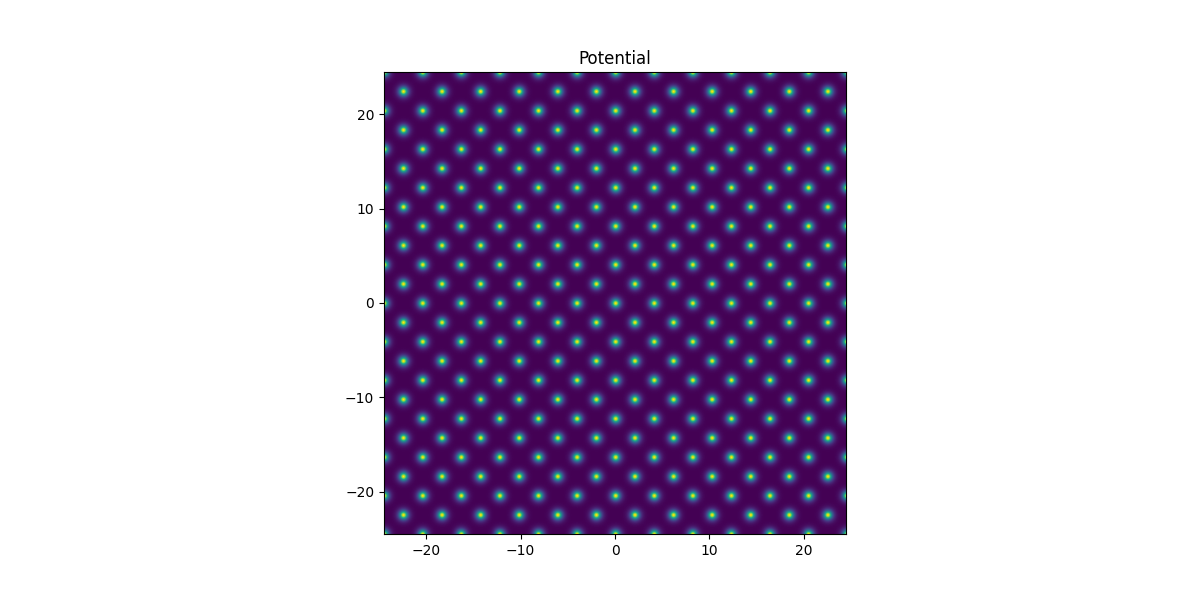

In [287]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.imshow(V[2, :, :], extent = (-half_x, half_x, -half_y, half_y))
ax.set_title('Potential')


Set up refractive index potential

In [288]:
if xp == cp:
    V = cp.array(V)
    

k = 2 * xp.pi / wavelength

V_xyz = PHI_0 - V.T

n = xp.sqrt(V_xyz / PHI_0)
dndx, dndy, dndz = xp.gradient(n)

print('Shape of Potential', n.shape)

nx, ny, nz = V.T.shape

x = xp.linspace(-half_x, half_x, nx, endpoint = False)  # x coordinates
y = xp.linspace(-half_y, half_y, ny, endpoint = False)  # y coordinates
z = xp.linspace(-half_z, half_z, nz, endpoint = True)  # z coordinates

n_interp = RegularGridInterpolator((x, y, z), n, method = 'linear', bounds_error=False, fill_value=1.0)
dndx_interp = RegularGridInterpolator((x, y, z), dndx, method = 'linear', bounds_error=False, fill_value=0.0)
dndy_interp = RegularGridInterpolator((x, y, z), dndy, method = 'linear', bounds_error=False, fill_value=0.0)
dndz_interp = RegularGridInterpolator((x, y, z), dndz, method = 'linear', bounds_error=False, fill_value=0.0)

xx, yy = xp.meshgrid(x, y)

Shape of Potential (980, 980, 21)


Set up ray coordinates

In [289]:
num_rays = int(1e5)

z0_atom = -half_z
dz = slice_thickness

# Generate random angles and radii
angles = xp.random.uniform(0, 2 * xp.pi, num_rays)
radii = xp.random.uniform(0, 10, num_rays)

x0s = radii * xp.cos(angles)
y0s = radii * xp.sin(angles)

z0 = -1000

dx0 = 0.0
dy0 = 0.0
opl0 = 0.0

rho = xp.sqrt(dx0 ** 2 + dy0 ** 2)
dz0 = z0_atom - z0
z1 = z0 + dz0

r = xp.zeros((num_rays, num_slices + 3, 5))

z_sol = xp.zeros(num_slices + 3)
z_sol[0] = z0

r[:, 0, 0] = x0s
r[:, 0, 1] = dx0
r[:, 0, 2] = y0s
r[:, 0, 3] = dy0
r[:, 0, 4] = opl0


Numerically step rays through free space and potential slices

In [290]:
dzend = 1000000 #Angstroms

r[:, 1, :], z_sol[1] = step_z(r[:, 0, :], z_sol[0], dz0)

i_start = 1
for i in range(num_slices):
    r[:, i + i_start, :] = step_slice(r[:, i + i_start, :], z_sol[i + i_start], dz, n_interp, dndx_interp, dndy_interp, dndz_interp)
    r[:, i + i_start + 1, :], z_sol[i + i_start + 1] = step_z(r[:, i + i_start, :], z_sol[i + i_start], dz)

r[:, -1, :], z_sol[-1] = step_z(r[:, -2, :], z_sol[-2], dzend)

Setup detector pixels and size

In [291]:
n_pixels_x = 110
n_pixels_y = 110
det_width_x = 2
det_width_y = 2
z_pos = 0.0

det_image, det_points, det_shape, det_pixels_x, det_pixels_y = make_detector(n_pixels_x, 
                                                                             n_pixels_y, 
                                                                             det_width_x, 
                                                                             det_width_y,
                                                                             z_pos)

Need to do a quick test of plane wave accumulate, that if given a ray with a slope of 1, and knowing the size of the detector, we should expect a certain phase at the edges of the detector, calculated using simple trig. 

In [292]:
ray_points = cp.array([[0., 0., 0.]]).T
ray_phase = cp.array([0.0])
ray_unit_direction_vector = convert_slope_to_unit_vector(1.0, 0.0)[xp.newaxis]

det_image = plane_wave_accumulate(det_image,
                                  det_points,
                                  det_shape,
                                  ray_points,
                                  ray_unit_direction_vector,
                                  ray_phase,
                                  wavelength,
                                  num_rays=1,
                                  chunk_size=1)

np.angle mods the result between $- \pi$ and $\pi$, and our phase is between $0$ and  $2\pi$, so test passes I think.

1.8403023690212201 -1.8403023690212204


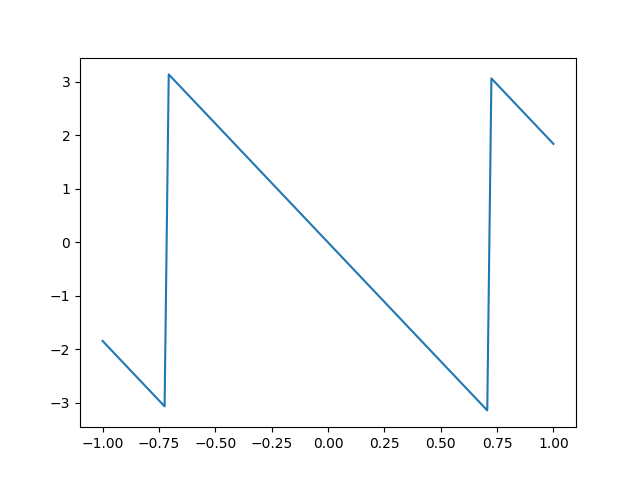

In [293]:
plt.figure()
plt.plot(det_pixels_x.get(), np.angle(det_image[0, :]))

# Calcul
opl_analytic = 1 * np.sin(np.arctan(1.0))
phase_analytic = get_phase_from_opl(opl_analytic, wavelength)

print(2*np.pi - phase_analytic, np.angle(det_image[0, 0]))

In [294]:
x, dx, y, dy, opl = r[:, -1, :].T
ray_unit_direction_vector = convert_slope_to_unit_vector(dx, dy).T
ray_points = xp.vstack([x, y, xp.ones(num_rays) * z_sol[-1]]).T
ray_phase = get_phase_from_opl(opl, wavelength)

In [299]:
n_pixels_x = 1000
n_pixels_y = 1000
det_width_x = 1000
det_width_y = 1000
z_pos = z_sol[-1]

det_image, det_points, det_shape, det_pixels_x, det_pixels_y = make_detector(n_pixels_x, 
                                                                             n_pixels_y, 
                                                                             det_width_x, 
                                                                             det_width_y,
                                                                             z_pos)

In [303]:
det_image = plane_wave_accumulate(det_image,
                                  det_points,
                                  det_shape,
                                  ray_points,
                                  ray_unit_direction_vector,
                                  ray_phase,
                                  wavelength,
                                  num_rays,
                                  chunk_size=100)

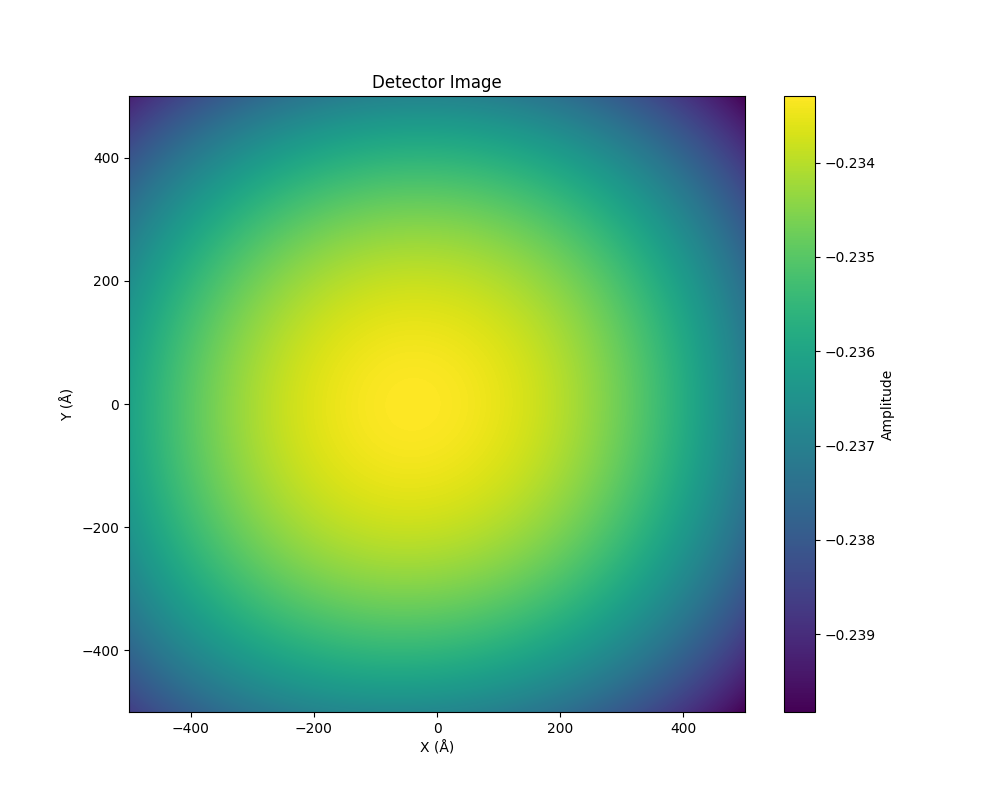

In [304]:

# Plotting the detector pixels
plt.figure(figsize=(10, 8))
plt.imshow(np.angle(det_image), extent=[-det_width_x/2, det_width_x/2, -det_width_y/2, det_width_y/2], cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.title('Detector Image')
plt.show()

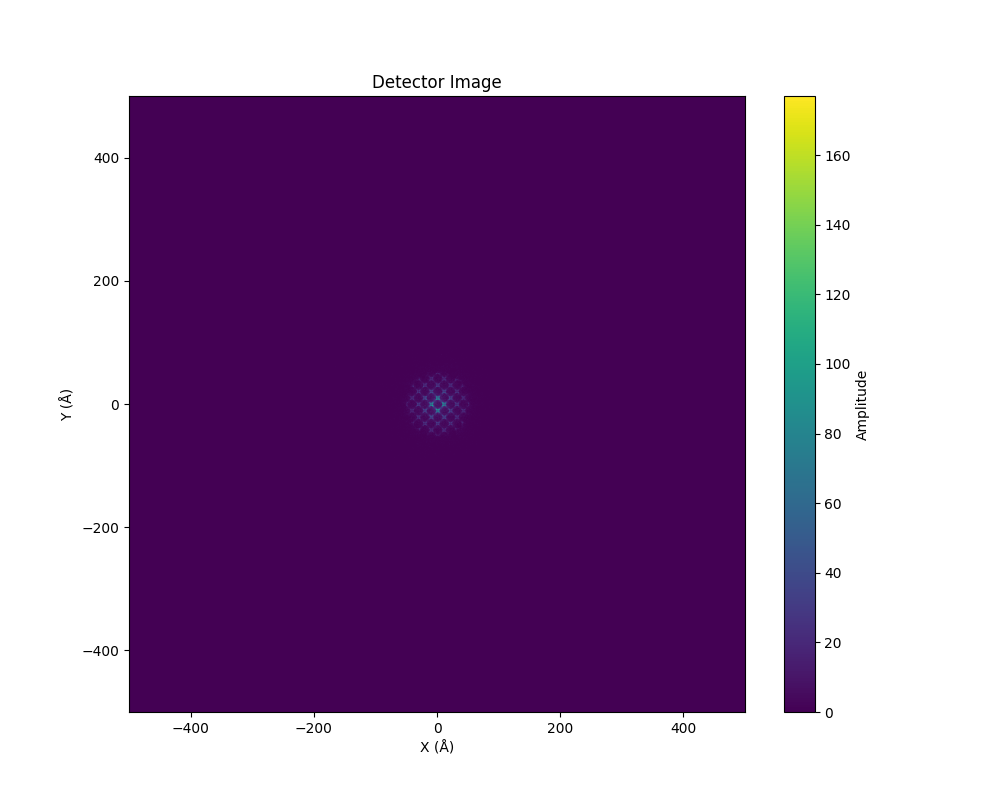

In [305]:
det_image = xp.zeros((n_pixels_x, n_pixels_y), xp.float64)
pixel_coords_x, pixel_coords_y = get_pixel_coords(x, y, det_shape, px_size_x)
pixel_coords_x, pixel_coords_y = xp.round((pixel_coords_x, pixel_coords_y)).astype(int)

sy, sx = det_shape

mask = xp.logical_and(
    xp.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sx
    ),
    xp.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sy
    )
)

# Get indices of ray locations on detector
flat_icds = xp.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_shape
)

# Add phase at each pixel
xp.add.at(
    det_image.ravel(),
    flat_icds,
    1.0,
)
# If det_image is on GPU, transfer it back to CPU if needed
det_image = xp.asnumpy(det_image)

# Plotting the detector pixels
plt.figure(figsize=(10, 8))
plt.imshow(det_image, extent=[-det_width_x/2, det_width_x/2, -det_width_y/2, det_width_y/2], cmap='viridis')
plt.colorbar(label='Amplitude')
plt.xlabel('X (Å)')
plt.ylabel('Y (Å)')
plt.title('Detector Image')
plt.show()